# Introduction
In this notebook..<br>
Source: https://www.kaggle.com/code/mmdatainfo/k-nearest-neighbors<br>
The original text by the author is written in gray to improve readability<br>
Support: used chatgpt and github copilot

# Change Log
Summary of the changes made:
<ol>
    <li>Added some comments added to the code</li>
    <li>Added an example for classification</li>
    <li>Added an example for regression</li>
    <li>The white markdown sections were added to explain some of the code fragments</li>
    <li>Fixed some small errors in the code written by the author</li>
</ol>

# <span style="color: grey;">k-Nearest Neighbors (kNN)
<span style="color: grey;">
This Jupyter notebook summarizes the <a href=#pros>Pros</a> and <a href=#cons>Cons</a> of the k-Nearest Neighbors algorithm and gives two Python examples on usage for <a href=#clas>Classification</a> and <a href=#reg>Regression</a>. 
</span>

## <span style="color: grey;">Theory<sup>1,2,3</sup> 
<span style="color: grey;">
* Is a non-probabilistic, non-parametric and instance-based learning algorithm (see <a href=#reference>References</a>:
    * **Non-parametric** means it makes no explicit assumptions about the function form of _h_, avoiding the dangers of mis-modelling the underlying distribution of the data
        * For example, suppose our data is highly non-Gaussian but the learning model was choose assumes a Gaussian form. In that case, a parametric algorithm would make extremely poor predictions.
    * **Instance-based** learning means that the algorithm does not explicitly learn a model
        * Instead, it chooses to memorize the training instances which are subsequently used as "knowledge" for the prediction phase
        * Concretely, this means that only when a query to our database is made (i.e., when we ask it to predict a label given an input), will the algorithm use the training instances to predict the result
</span>

### <span style="color: grey;">Pros<a name="pros"/> 
<span style="color: grey;">
* **simple** to understand and implement
* with **little to zero training time**
* kNN **works just as easily with multi-class data** sets whereas other algorithms are hard-coded for the binary setting
* the non-parametric nature of kNN gives it an edge in certain settings where the data may be highly unusual, thus **without prior knowledge on distribution**
</span>

### <span style="color: grey;">Cons<a name="cons"/> 
<span style="color: grey;">
* **computationally expensive** testing phase
    * we **need to store the whole data set for each decision**!
* can **suffer from skewed class distributions**
    * for example, if a certain class is very frequent in the training set, it will tend to dominate the majority voting of the new example (large number = more common)
* the accuracy can be severally **degraded with high-dimension data** because of the little difference between the nearest and farthest neighbor
    * **the curse of dimensionality** refers to various phenomena that arise when analyzing and organizing data in high-dimensional spaces that do not occur in low-dimensional settings such as the three-dimensional physical space of everyday experience
    * for high-dimensional data (e.g., with number of dimensions more than 10) **scaling** and **dimension reductions** (such as PCA) is usually performed prior applying kNN
</span>
    
### <span style="color: grey;">References<a name="reference"/>  
<span style="color: grey;">
* <sup>1</sup>Wikipedia [kNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) 
* <sup>2</sup>Sklearn [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
* <sup>3</sup>[Complete Guide to K-Nearest-Neighbors](https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor)
</span>

## <span style="color: grey;">Classification<a name="clas"/> 
<span style="color: grey;">
* the output is a class membership
* an object is classified by a **majority vote** of its neighbours, with the object being assigned to the class most common among its k nearest neighbours
    * if k = 1, then the object is simply assigned to the class of that nearest neighbour
</span>
    
### <span style="color: grey;">Example: predict [IRIS](https://scikit-learn.org/stable/datasets/index.html#iris-dataset) <span style="color: grey;">class

<span style="color: grey;">Set environment

In [7]:
# Scikit-learn
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
# other libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
# Use vector drawing inside jupyter notebook
%config InlineBackend.figure_format = "svg"
# Set matplotlib default axis font size (inside this notebook)
plt.rcParams.update({'font.size': 8})

<span style="color: grey;">Load data

In [64]:
iris = datasets.load_iris()
# This is extra step that can be omitted but Pandas DataFrame contains some powerfull features
df = pd.DataFrame(iris.data,columns=iris.feature_names)
df = df.assign(target=iris.target)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


<span>
Changes Made:
<ol>
    <li>df.head() added so I could have a look at the data</li>
</ol>
</spam>

<span style="color: grey;">Show data summary: extend the `describe` method by selected stats
* <span style="color: grey;">See the Jupyter notebook on **Standard Procedure** for more details

In [66]:
# Compute selected stats
# This section gets information about the dataset such as missing values, and amount of overall values
# dfinfo is the dataframe containing all the datatypes in df
dfinfo = pd.DataFrame(df.dtypes,columns=["dtypes"])
# This gets the amount of entries in a column, as well as the missing values in each column
for (m,n) in zip([df.isna().sum()],["isna"]):
    # Merges the 2 new rows to the new dataframe
    dfinfo = dfinfo.merge(pd.DataFrame(m,columns=[n]),right_index=True,left_index=True,how="inner");
# Add to `describe` output
dfinfo = pd.concat([dfinfo.T, df.describe()])
dfinfo.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
dtypes,float64,float64,float64,float64,int64
isna,0,0,0,0,0
count,150.0,150.0,150.0,150.0,150.0
mean,5.843333,3.057333,3.758,1.199333,1.0
std,0.828066,0.435866,1.765298,0.762238,0.819232


<span>
Changes Made:
<ol>
    <li>Added Comments</li>
    <li>Switched dfinfo.T.append(df.describe()) to dfinfo = pd.concat([dfinfo.T, df.describe()])</li>
    <li>DFinfo.head() added</li>
    <li>Removed the duplicate count row</li>
</ol>
</spam>

<span style="color: grey;">Show histogram (distribution)

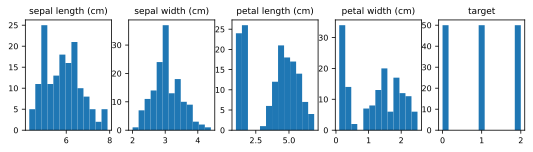

In [57]:
# Shows details about the dataset
plt.figure(figsize=(9,2))
for (i,v) in enumerate(df.columns):
    plt.subplot(1,df.shape[1],i+1);
    plt.hist(df.iloc[:,i],bins="sqrt")
    plt.title(v,fontsize=9);

<span>
Changes Made:
<ol>
    <li>Added Comments</li>
    <li>Switched df.columns[i] to just a v</li>
</ol>
</spam>

<span style="color: grey;">Show correlation matrix

In [58]:
df.corr().round(2).style.background_gradient(cmap="viridis")

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.120000,0.870000,0.820000,0.780000
sepal width (cm),-0.120000,1.000000,-0.430000,-0.370000,-0.430000
petal length (cm),0.870000,-0.430000,1.000000,0.960000,0.950000
petal width (cm),0.820000,-0.370000,0.960000,1.000000,0.960000
target,0.780000,-0.430000,0.950000,0.960000,1.000000


<span style="color: grey;">Scale and try to **reduce dimensions**: what we try to do is to **always simply the model** if possible (see correlation matrix above)
* <span style="color: grey;">More complex model (e.g., more features, or higher _*k*_) will (in theory) increase the probability of higher "out of sample" error (even when "in sample" error = train set) will be smaller!
* <span style="color: grey;">Use either 99% threshold (own subjective) or "mle" algorithm (more objective)
*<span style="color: grey;"> Use **linear** scaler (transformation)
* <span style="color: grey;">Here, the data is scaled prior train-test split. 
    * <span style="color: grey;">In real applications, first split and scale afterwards, to simulate real-world scenario where we do not have the test set! (otherwise data snooping effect)

In [ ]:
# Scales the values
scale = StandardScaler(with_mean=True,with_std=True);
Xo = scale.fit_transform(df.drop(["target"],axis=1).values);

In [ ]:
# PCA will choose enough principal components to explain 99% of the variance in the data
# mle alternatively will use maximum likelihood estimation to choose the optimal number of components
pca = PCA(n_components=0.99)# or set n_components="mle"
# Computes the principal components and transforms the dataset to apply those principal components
X = pca.fit_transform(Xo)
print("Nr. of features after PCA = {} (input = {})".format(X.shape[1],Xo.shape[1]))

Nr. of features after PCA = 3 (input = 4)


As you can see above the features are reduced from 3 to 4

<span style="color: grey;">Prepare for fitting

In [ ]:
# encode target values (is not necessary for IRIS but still:-)
# Encodes categorial labels like height to numerical values like 0
y = LabelEncoder().fit_transform(df["target"].values);
# Split 2/3 to 1/3 train to test respectively
[X_train,X_test,y_train,y_test] = train_test_split(X,y,train_size = 0.67,test_size = 0.33,
                                                   stratify=y,random_state=123);

#### <span style="color: grey;">Find optimal model
* <span style="color: grey;">Considering the small data set (150 samples), find "optimal" k setting it to maximum of 5
    * <span style="color: grey;">Optimal in terms of accuracy
    * <span style="color: grey;">Simple model = higher probability of lower in and out-of sample error

In [ ]:
# Sets the model to auto which means the algorithm will automatically choose the best method for calculating the nearest neighbour
model = KNeighborsClassifier(algorithm="auto");
parameters = {"n_neighbors":[1,3,5],
              "weights":["uniform","distance"]}
# Will try the most optimal combination of n_neighbours and weights to get the most optimal model
model_optim = GridSearchCV(model, parameters, cv=5,scoring="accuracy");

In [11]:
model_optim.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 3, 5],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

<span style="color: grey;">Show the "optimal" settings for kNN

In [12]:
model_optim.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

#### <span style="color: grey;">Show resulting accuracy

In [13]:
for (i,x,y) in zip(["Train","Test"],[X_train,X_test],[y_train,y_test]):
    print("Classification kNN",i," report:\n",classification_report(y,model_optim.predict(x)))

Classification kNN Train  report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        33

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Classification kNN Test  report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.88      0.94        17
           2       0.89      1.00      0.94        17

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



<span style="color: grey;">In this case, the precision (accuracy=macro avg precision) is very high. 
Just to show that that is not coincidence compare to "dummy" model (most frequent & uniform distribution)

In [14]:
for i in ["most_frequent","uniform"]:
    dummy = DummyClassifier(strategy=i).fit(X_train,y_train);
    print("Classification ",i," test report:",classification_report(y_test,dummy.predict(X_test)))

Classification  most_frequent  test report:               precision    recall  f1-score   support

           0       0.32      1.00      0.48        16
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        17

    accuracy                           0.32        50
   macro avg       0.11      0.33      0.16        50
weighted avg       0.10      0.32      0.16        50

Classification  uniform  test report:               precision    recall  f1-score   support

           0       0.33      0.38      0.35        16
           1       0.47      0.41      0.44        17
           2       0.35      0.35      0.35        17

    accuracy                           0.38        50
   macro avg       0.38      0.38      0.38        50
weighted avg       0.39      0.38      0.38        50



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Classification Example: Car Evaluation Model

#### Introduction
This dataset can be found here <a href="https://archive.ics.uci.edu/dataset/19/car+evaluation">link</a><br>
In this dataset there are 7 columns:<br>
<ul>
    <li>buying - buying price</li>
    <li>maint - price of the maintenance</li>
    <li>doors - number of doors</li>
    <li>persons - capacity in terms of persons to carry</li>
    <li>lug_boot - the size of luggage boot</li>
    <li>safety - estimated safety of the car</li>
    <li>class - evaluation level</li>
</ul>

What I am going to try to do is develop a KNN model that takes in those 6 features and tries to predict the category in the class value wether a car is in a unacceptable, acceptable, good or very good condition. 

#### Dataset Preprocessing
Below i just import the dataset

In [59]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19) 
  
# data (as pandas dataframes) 
X = car_evaluation.data.features 
y = car_evaluation.data.targets 
  
# metadata 
print(car_evaluation.metadata) 
  
# variable information 
print(car_evaluation.variables) 


{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'ID': 249, 'type': 'NATIVE', 'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'venue': '8th Intl Workshop on Expert Systems and their Applications, 

Here I convert the data above into a pandas data frame.

In [60]:
import pandas as pd
df = pd.DataFrame(car_evaluation.data.features)
df['class'] = y
df.tail()

,buying,maint,doors,persons,lug_boot,safety,class
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good
1727,low,low,5more,more,big,high,vgood


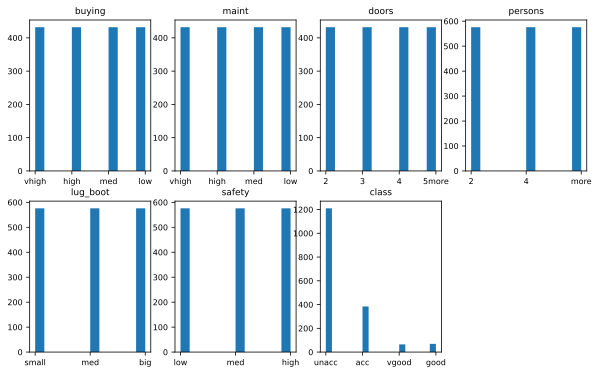

In [61]:
# Shows details about the dataset
plt.figure(figsize=(10,6))
for (i,v) in enumerate(df.columns):
    plt.subplot(2,4,i+1);
    plt.hist(df.iloc[:,i],bins="auto")
    plt.title(v,fontsize=9);

Here I wanted to show the distribution of the different features and the target. As you can see the values on the features are very evenly spread out.

As this point I learned that knn works best with numerical features, so I decided to switch to a different dataset to better fit the model.

### Classification Example: Dry Bean Classifier

#### Introduction
This dataset can be found here: <a hred="https://archive.ics.uci.edu/dataset/602/dry+bean+dataset">link</a><br>
This dataset contains information about 13,611 grains of 7 different categories of dry beans. The columns compose of 12 dimensions of the beans and 4 shape factors, the exact shape factors were not identified in the dataset. The data in the columns was taken from high resolution images.<br>
The columns in the data include:<br>
1.) Area (A): The area of a bean zone and the number of pixels within its boundaries.<br>
2.) Perimeter (P): Bean circumference is defined as the length of its border.<br>
3.) Major axis length (L): The distance between the ends of the longest line that can be drawn from a bean.<br>
4.) Minor axis length (l): The longest line that can be drawn from the bean while standing perpendicular to the main axis.<br>
5.) Aspect ratio (K): Defines the relationship between L and l.<br>
6.) Eccentricity (Ec): Eccentricity of the ellipse having the same moments as the region.<br>
7.) Convex area (C): Number of pixels in the smallest convex polygon that can contain the <br>area of a bean seed.
8.) Equivalent diameter (Ed): The diameter of a circle having the same area as a bean seed area.<br>
9.) Extent (Ex): The ratio of the pixels in the bounding box to the bean area.<br>
10.)Solidity (S): Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.<br>
11.)Roundness (R): Calculated with the following formula: (4piA)/(P^2)<br>
12.)Compactness (CO): Measures the roundness of an object: Ed/L<br>
13.)ShapeFactor1 (SF1)<br>
14.)ShapeFactor2 (SF2)<br>
15.)ShapeFactor3 (SF3)<br>
16.)ShapeFactor4 (SF4)<br>
17.)Class (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)<br>

In this example I will be attempting to create a KNN model that correctly predicts the category a bean belongs to depending on the features provided.

#### Data Preprocessing
In this section I just import and prepare the data to be used on the model provided above

Below I import the dataset

In [67]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
dry_bean = fetch_ucirepo(id=602) 
  
# data (as pandas dataframes) 
X = dry_bean.data.features 
y = dry_bean.data.targets 
  
# metadata 
print(dry_bean.metadata) 
  
# variable information 
print(dry_bean.variables) 


{'uci_id': 602, 'name': 'Dry Bean', 'repository_url': 'https://archive.ics.uci.edu/dataset/602/dry+bean+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/602/data.csv', 'abstract': 'Images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. A total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 13611, 'num_features': 16, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Thu Mar 28 2024', 'dataset_doi': '10.24432/C50S4B', 'creators': [], 'intro_paper': {'ID': 244, 'type': 'NATIVE', 'title': 'Multiclass classification of dry beans using computer vision and machine learning techniques', 'authors': 'M. Koklu, Ilker Ali Özkan', 'venue': 'Co

Here I conver the dataset into pandas dataframe

In [68]:
import pandas as pd
df = pd.DataFrame(X)
df['Class'] = y
df.tail()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653247,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON
13610,42159,772.237,295.142741,182.204716,1.619841,0.786693,42600,231.686223,0.788962,0.989648,0.888380,0.784997,0.007001,0.001640,0.616221,0.998180,DERMASON


In the section below I add a column for the encoded number associated with each value in the target column

In [69]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

le = LabelEncoder()
df['Class_encoded'] = le.fit_transform(df['Class'])
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class,Class_encoded
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER,5
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER,5
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER,5
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER,5
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER,5


In [70]:
label_mapping = {category: code for category, code in zip(le.classes_, range(len(le.classes_)))}
print("Label Mapping:", label_mapping)

Label Mapping: {'BARBUNYA': 0, 'BOMBAY': 1, 'CALI': 2, 'DERMASON': 3, 'HOROZ': 4, 'SEKER': 5, 'SIRA': 6}


As you can see above the unique values in the class column have been mapped with the following values:
<ul>
<li>BARBUNYA: 0 
<li>BOMBAY: 1
<li>CALI: 2
<li>DERMASON: 3 
<li>HOROZ: 4 
<li>SEKER: 5 
<li>SIRA: 6
</ul>

In this section below I check the metadata of the dataset

In [71]:
# Compute selected stats
# This section gets information about the dataset such as missing values, and amount of overall values
# dfinfo is the dataframe containing all the datatypes in df
dfinfo = pd.DataFrame(df.dtypes,columns=["dtypes"])
# This gets the amount of entries in a column, as well as the missing values in each column
for (m,n) in zip([df.isna().sum()],["isna"]):
    # Merges the 2 new rows to the new dataframe
    dfinfo = dfinfo.merge(pd.DataFrame(m,columns=[n]),right_index=True,left_index=True,how="inner");
# Add to `describe` output
dfinfo = pd.concat([dfinfo.T, df.describe()])
dfinfo.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class,Class_encoded
dtypes,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64
isna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
count,13611.0,13611.0,13611.0,13611.0,13611.0,13611.0,13611.0,13611.0,13611.0,13611.0,13611.0,13611.0,13611.0,13611.0,13611.0,13611.0,NaN,13611.0
mean,53048.284549,855.283459,320.141867,202.270714,1.583242,0.750895,53768.200206,253.06422,0.749733,0.987143,0.873282,0.799864,0.006564,0.001716,0.64359,0.995063,NaN,3.532657
std,29324.095717,214.289696,85.694186,44.970091,0.246678,0.092002,29774.915817,59.17712,0.049086,0.00466,0.05952,0.061713,0.001128,0.000596,0.098996,0.004366,NaN,1.828709


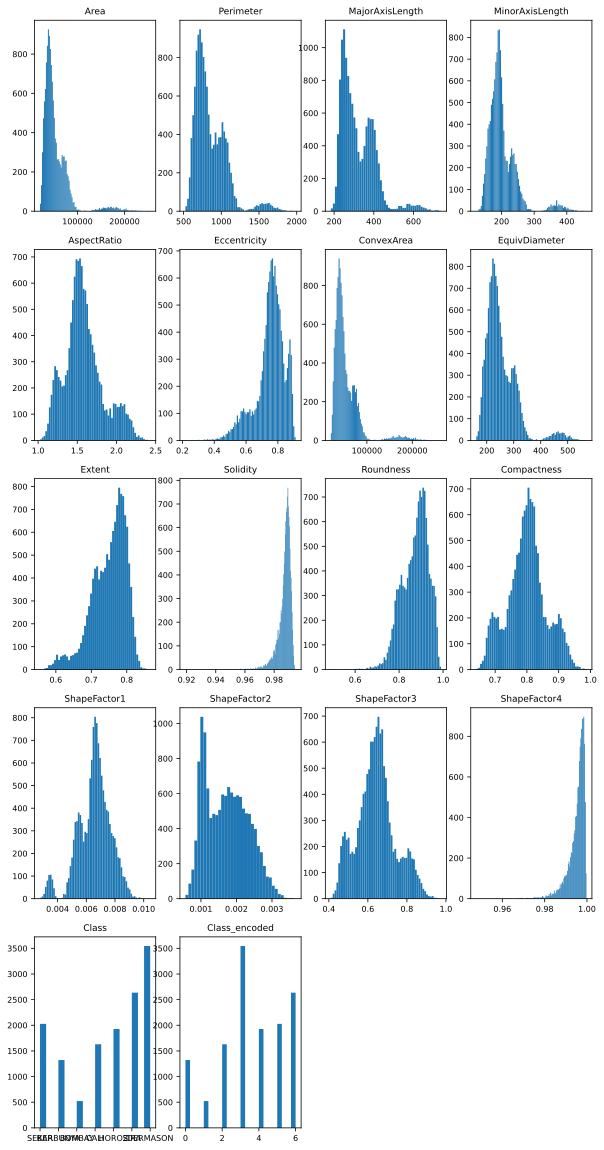

In [72]:
# Shows details about the dataset
plt.figure(figsize=(10,20))
for (i,v) in enumerate(df.columns):
    plt.subplot(5,4,i+1);
    plt.hist(df.iloc[:,i],bins="auto")
    plt.title(v,fontsize=9);

A correlation matrix is a way to show what feautres have a correlation with other features:<br>
1 - Strong positive correlation<br>
0 - No correlation<br>
-1 - Strong negative correlation<br>

In [51]:
df.drop(columns=['Class']).corr().round(2).style.background_gradient(cmap="viridis")

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class_encoded
Area,1.000000,0.970000,0.930000,0.950000,0.240000,0.270000,1.000000,0.980000,0.050000,-0.200000,-0.360000,-0.270000,-0.850000,-0.640000,-0.270000,-0.360000,-0.480000
Perimeter,0.970000,1.000000,0.980000,0.910000,0.390000,0.390000,0.970000,0.990000,-0.020000,-0.300000,-0.550000,-0.410000,-0.860000,-0.770000,-0.410000,-0.430000,-0.510000
MajorAxisLength,0.930000,0.980000,1.000000,0.830000,0.550000,0.540000,0.930000,0.960000,-0.080000,-0.280000,-0.600000,-0.570000,-0.770000,-0.860000,-0.570000,-0.480000,-0.460000
MinorAxisLength,0.950000,0.910000,0.830000,1.000000,-0.010000,0.020000,0.950000,0.950000,0.150000,-0.160000,-0.210000,-0.020000,-0.950000,-0.470000,-0.020000,-0.260000,-0.460000
AspectRatio,0.240000,0.390000,0.550000,-0.010000,1.000000,0.920000,0.240000,0.300000,-0.370000,-0.270000,-0.770000,-0.990000,0.020000,-0.840000,-0.980000,-0.450000,-0.120000
Eccentricity,0.270000,0.390000,0.540000,0.020000,0.920000,1.000000,0.270000,0.320000,-0.320000,-0.300000,-0.720000,-0.970000,0.020000,-0.860000,-0.980000,-0.450000,-0.200000
ConvexArea,1.000000,0.970000,0.930000,0.950000,0.240000,0.270000,1.000000,0.990000,0.050000,-0.210000,-0.360000,-0.270000,-0.850000,-0.640000,-0.270000,-0.360000,-0.480000
EquivDiameter,0.980000,0.990000,0.960000,0.950000,0.300000,0.320000,0.990000,1.000000,0.030000,-0.230000,-0.440000,-0.330000,-0.890000,-0.710000,-0.330000,-0.390000,-0.480000
Extent,0.050000,-0.020000,-0.080000,0.150000,-0.370000,-0.320000,0.050000,0.030000,1.000000,0.190000,0.340000,0.350000,-0.140000,0.240000,0.350000,0.150000,-0.030000
Solidity,-0.200000,-0.300000,-0.280000,-0.160000,-0.270000,-0.300000,-0.210000,-0.230000,0.190000,1.000000,0.610000,0.300000,0.150000,0.340000,0.310000,0.700000,0.320000


#### The KNN Model

In [73]:
# Dropping the non-numerical target column
df = df.drop(columns=['Class'])
scale = StandardScaler(with_mean=True,with_std=True);
Xo = scale.fit_transform(df.drop(["Class_encoded"],axis=1).values);

PCA (Principal component Analysis) is a technique that helps simplify complex datasets. It creates new features called principal components out fo the features previously shown. It chooses the principal components by finding the features that have the greatest variance between them. Below is an example of how that is used in python.

In [74]:
# PCA will choose enough principal components to explain 99% of the variance in the data
# mle alternatively will use maximum likelihood estimation to choose the optimal number of components
pca = PCA(n_components=0.99)# or set n_components="mle"
# Computes the principal components and transforms the dataset to apply those principal components
X = pca.fit_transform(Xo)
print("Nr. of features after PCA = {} (input = {})".format(X.shape[1],Xo.shape[1]))

Nr. of features after PCA = 7 (input = 16)


Data is split into trainining and dataset in 3:1 ratio

In [75]:
y = df['Class_encoded']
[X_train,X_test,y_train,y_test] = train_test_split(X,y,train_size = 0.67,test_size = 0.33,
                                                   stratify=y,random_state=123);

Below I try to find the best model for this dataset

In [77]:
# Sets the model to auto which means the algorithm will automatically choose the best method for calculating the nearest neighbour
model = KNeighborsClassifier(algorithm="auto");
parameters = {"n_neighbors":[1,3,5],
              "weights":["uniform","distance"]}
# Will try the most optimal combination of n_neighbours and weights to get the most optimal model
model_optim = GridSearchCV(model, parameters, cv=5,scoring="accuracy");

In [80]:
model_optim.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [81]:
print("Best Parameters:", model_optim.best_params_)

Best Parameters: {'n_neighbors': 5, 'weights': 'distance'}


In [82]:
print(model_optim.best_estimator_)

KNeighborsClassifier(weights='distance')


As you can see above the weight distance with 5 n neighbors was chosen as the best suited model.

Below is a classification report which shows how well the model did on the train and test data

In [58]:
for (i,x,y) in zip(["Train","Test"],[X_train,X_test],[y_train,y_test]):
    print("Classification kNN",i," report:\n",classification_report(y,model_optim.predict(x)))

Classification kNN Train  report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       885
           1       1.00      1.00      1.00       350
           2       1.00      1.00      1.00      1092
           3       1.00      1.00      1.00      2376
           4       1.00      1.00      1.00      1292
           5       1.00      1.00      1.00      1358
           6       1.00      1.00      1.00      1766

    accuracy                           1.00      9119
   macro avg       1.00      1.00      1.00      9119
weighted avg       1.00      1.00      1.00      9119

Classification kNN Test  report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       437
           1       1.00      1.00      1.00       172
           2       0.94      0.93      0.93       538
           3       0.91      0.91      0.91      1170
           4       0.95      0.94      0.95       636
         

As you can see the accuray for this model is pretty high, below you can see it compared to the dummy model. The model has 100% accuracy when predicting Bombay beans. This could be to several factors such as Bombay beans being very easy to distinguish. It has the most difficult timne predicing Sira beans with 16% inaccuracy rate. 

In [59]:
for i in ["most_frequent","uniform"]:
    dummy = DummyClassifier(strategy=i).fit(X_train,y_train);
    print("Classification ",i," test report:",classification_report(y_test,dummy.predict(X_test)))

Classification  most_frequent  test report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00       437
           1       0.00      0.00      0.00       172
           2       0.00      0.00      0.00       538
           3       0.26      1.00      0.41      1170
           4       0.00      0.00      0.00       636
           5       0.00      0.00      0.00       669
           6       0.00      0.00      0.00       870

    accuracy                           0.26      4492
   macro avg       0.04      0.14      0.06      4492
weighted avg       0.07      0.26      0.11      4492

Classification  uniform  test report:               precision    recall  f1-score   support

           0       0.09      0.13      0.11       437
           1       0.04      0.15      0.06       172
           2       0.12      0.14      0.13       538
           3       0.24      0.14      0.17      1170
           4       0.14      0.13      0.14       

C:\Users\dawid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dawid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dawid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

#### Conclusion 
In conclusion I managed to develop a KNN model that can accurately predict to what type a dried bean belongs to based on specific parameters. This model has about a 92% accuracy.

## <span style="color: grey;">Regression<a name="reg"/></a>
* <span style="color: grey;">Predicts value as the **average of the values** of its k nearest neighbors</span>

### <span style="color: grey;">Example: Predict House price
* <span style="color: grey;">Use Scikit-learn [California Housing](https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset) data set
    * <span style="color: grey;">This is a large data set that allows us to use more complex model
* <span style="color: grey;">Nontheless, try to reduce the number of features: via visual inspection and using PCA

<span style="color: grey;">Load data

In [85]:
# house = datasets.fetch_california_housing()
# df = pd.DataFrame(house.data,columns=house.feature_names)
# df = df.assign(target=house.target)

In [ ]:
df = pd.read_csv("../input/test-data/california_housing.csv").drop(columns=["Unnamed: 0"],errors='ignore')

<span style="color: grey;">Inspect data: show statistics, histogram and correlation 

In [ ]:
# Compute selected stats
dfinfo = pd.DataFrame(df.dtypes,columns=["dtypes"])
for (m,n) in zip([df.count(),df.isna().sum()],["count","isna"]):
    dfinfo = dfinfo.merge(pd.DataFrame(m,columns=[n]),right_index=True,left_index=True,how="inner");
# Add to `describe` output
dfinfo.T.append(df.describe())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
dtypes,float64,float64,float64,float64,float64,float64,float64,float64,float64
count,20640,20640,20640,20640,20640,20640,20640,20640,20640
isna,0,0,0,0,0,0,0,0,0
count,20640,20640,20640,20640,20640,20640,20640,20640,20640
mean,3.87067,28.6395,5.429,1.09668,1425.48,3.07066,35.6319,-119.57,2.06856
std,1.89982,12.5856,2.47417,0.473911,1132.46,10.386,2.13595,2.00353,1.15396
min,0.4999,1,0.846154,0.333333,3,0.692308,32.54,-124.35,0.14999
25%,2.5634,18,4.44072,1.00608,787,2.42974,33.93,-121.8,1.196
50%,3.5348,29,5.22913,1.04878,1166,2.81812,34.26,-118.49,1.797
75%,4.74325,37,6.05238,1.09953,1725,3.28226,37.71,-118.01,2.64725


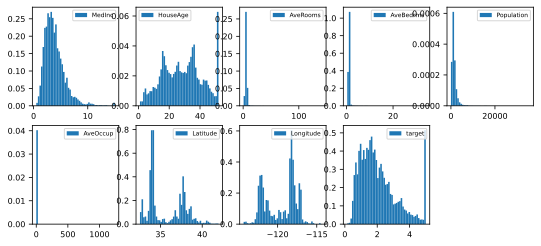

In [ ]:
plt.figure(figsize=(9,4))
for (i,v) in enumerate(df.columns):
    plt.subplot(2,5,i+1);
    plt.hist(df.iloc[:,i],50,density=True)
    plt.legend([df.columns[i]],fontsize=6);

In [ ]:
df.corr().round(2).style.background_gradient(cmap="viridis")

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
MedInc,1,-0.12,0.33,-0.06,0,0.02,-0.08,-0.02,0.69
HouseAge,-0.12,1,-0.15,-0.08,-0.3,0.01,0.01,-0.11,0.11
AveRooms,0.33,-0.15,1,0.85,-0.07,-0,0.11,-0.03,0.15
AveBedrms,-0.06,-0.08,0.85,1,-0.07,-0.01,0.07,0.01,-0.05
Population,0,-0.3,-0.07,-0.07,1,0.07,-0.11,0.1,-0.02
AveOccup,0.02,0.01,-0,-0.01,0.07,1,0,0,-0.02
Latitude,-0.08,0.01,0.11,0.07,-0.11,0,1,-0.92,-0.14
Longitude,-0.02,-0.11,-0.03,0.01,0.1,0,-0.92,1,-0.05
target,0.69,0.11,0.15,-0.05,-0.02,-0.02,-0.14,-0.05,1


#### <span style="color: grey;">Supervised Reduction
* <span style="color: grey;">Considering the correlation, histogram and the summary table:
    * <span style="color: grey;">Remove/drop "AveOccup" (average house occupancy)

In [ ]:
df = df.drop(["AveOccup"],axis=1)

<span style="color: grey;">Prepare for fitting by scaling data set
* <span style="color: grey;">Here, the data is scaled prior train-test split. 
    * <span style="color: grey;">In real applications, first split and scale afterwards, to simulate real-world scenario where we do not have the test set!

In [ ]:
X = StandardScaler().fit_transform(df.drop("target",axis=1).values);
y = df.target.values

In [ ]:
X = PCA(n_components="mle").fit_transform(X)
print("Nr. of features after reduction = {} (input = {})".format(X.shape[1],df.shape[1]))

Nr. of features after reduction = 6 (input = 8)


#### <span style="color: grey;">Fit model

In [ ]:
[X_train,X_test,y_train,y_test] = train_test_split(X,y,train_size=0.67,test_size=0.33,
                                                   random_state=123);

In [ ]:
knn = KNeighborsRegressor();
parameters = {"n_neighbors":[1,3,5,7,9],
              "weights":["uniform","distance"]}
knn_reg = GridSearchCV(knn, parameters, cv=5, scoring="neg_mean_squared_error");

In [ ]:
knn_reg.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
knn_reg.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='distance')

In [ ]:
print("Regression kNN (test) RMSE \t= {:.0f} *1000$".format(
    100*np.sqrt(mean_squared_error(knn_reg.predict(X_test),y_test))))

Regression kNN (test) RMSE 	= 65 *1000$


<span style="color: grey;">Compare to dummy

In [ ]:
for i in ["mean","median"]:
    dummy = DummyRegressor(strategy=i).fit(X_train,y_train);
    print("Regression ",i,"(test) RMSE \t= {:.0f} *1000$".format(
        100*np.sqrt(mean_squared_error(y_test,dummy.predict(X_test)))))

Regression  mean (test) RMSE 	= 116 *1000$
Regression  median (test) RMSE 	= 118 *1000$


### Regression Example: Concrete Compressive Strength Predictor

#### Introduction
This data set can be found here https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength

#### Data Preprocessing

In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
concrete_compressive_strength = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete_compressive_strength.data.features 
y = concrete_compressive_strength.data.targets 
  
# metadata 
print(concrete_compressive_strength.metadata) 
  
# variable information 
print(concrete_compressive_strength.variables) 

{'uci_id': 165, 'name': 'Concrete Compressive Strength', 'repository_url': 'https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength', 'data_url': 'https://archive.ics.uci.edu/static/public/165/data.csv', 'abstract': 'Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. ', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1030, 'num_features': 8, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Concrete compressive strength'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5PK67', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 383, 'type': 'NATIVE', 'title': 'Modeling of strength of high-performance concrete using artificial neural networks', 'authors': 'I. Yeh', 'venue': 'C

In [ ]:
import pandas as pd
df = pd.DataFrame(X)
df['Concrete compressive strength'] = y
df.tail()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77
1029,260.9,100.5,78.3,200.6,8.6,864.5,761.5,28,32.40


In [87]:
# Compute selected stats
# This section gets information about the dataset such as missing values, and amount of overall values
# dfinfo is the dataframe containing all the datatypes in df
dfinfo = pd.DataFrame(df.dtypes,columns=["dtypes"])
# This gets the amount of entries in a column, as well as the missing values in each column
for (m,n) in zip([df.isna().sum()],["isna"]):
    # Merges the 2 new rows to the new dataframe
    dfinfo = dfinfo.merge(pd.DataFrame(m,columns=[n]),right_index=True,left_index=True,how="inner");
# Add to `describe` output
dfinfo = pd.concat([dfinfo.T, df.describe()])
dfinfo.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
dtypes,float64,float64,float64,float64,float64,float64,float64,int64,float64
isna,0,0,0,0,0,0,0,0,0
count,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0
mean,281.167864,73.895825,54.18835,181.567282,6.20466,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.17598,63.169912,16.705742


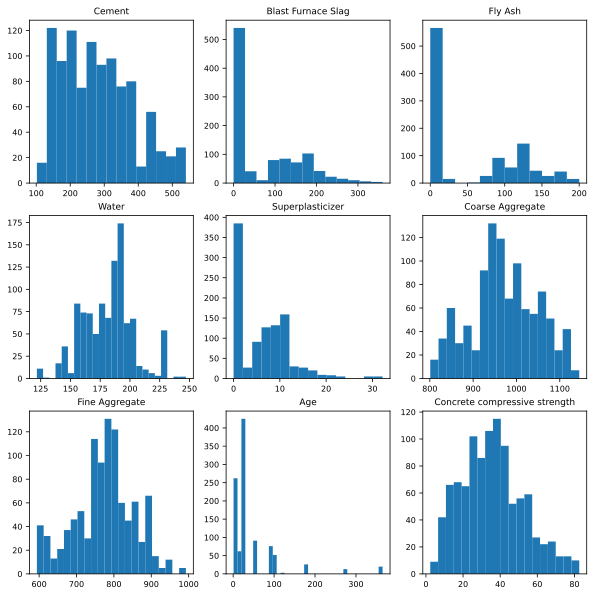

In [89]:
# Shows details about the dataset
plt.figure(figsize=(10,10))
for (i,v) in enumerate(df.columns):
    plt.subplot(3,3,i+1);
    plt.hist(df.iloc[:,i],bins="auto")
    plt.title(v,fontsize=9);

In [90]:
df.corr().round(2).style.background_gradient(cmap="viridis")

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
Cement,1.000000,-0.280000,-0.400000,-0.080000,0.090000,-0.110000,-0.220000,0.080000,0.500000
Blast Furnace Slag,-0.280000,1.000000,-0.320000,0.110000,0.040000,-0.280000,-0.280000,-0.040000,0.130000
Fly Ash,-0.400000,-0.320000,1.000000,-0.260000,0.380000,-0.010000,0.080000,-0.150000,-0.110000
Water,-0.080000,0.110000,-0.260000,1.000000,-0.660000,-0.180000,-0.450000,0.280000,-0.290000
Superplasticizer,0.090000,0.040000,0.380000,-0.660000,1.000000,-0.270000,0.220000,-0.190000,0.370000
Coarse Aggregate,-0.110000,-0.280000,-0.010000,-0.180000,-0.270000,1.000000,-0.180000,-0.000000,-0.160000
Fine Aggregate,-0.220000,-0.280000,0.080000,-0.450000,0.220000,-0.180000,1.000000,-0.160000,-0.170000
Age,0.080000,-0.040000,-0.150000,0.280000,-0.190000,-0.000000,-0.160000,1.000000,0.330000
Concrete compressive strength,0.500000,0.130000,-0.110000,-0.290000,0.370000,-0.160000,-0.170000,0.330000,1.000000


#### The KNN Model

In [91]:
X = StandardScaler().fit_transform(df.drop("Concrete compressive strength",axis=1).values);
y = df['Concrete compressive strength']

In [92]:
X = PCA(n_components="mle").fit_transform(X)
print("Nr. of features after reduction = {} (input = {})".format(X.shape[1],df.shape[1]))

Nr. of features after reduction = 7 (input = 9)


In [93]:
[X_train,X_test,y_train,y_test] = train_test_split(X,y,train_size=0.67,test_size=0.33,
                                                   random_state=123);

In [95]:
knn = KNeighborsRegressor();
parameters = {"n_neighbors":[1,3,5,7,9],
              "weights":["uniform","distance"]}
knn_reg = GridSearchCV(knn, parameters, cv=5, scoring="neg_mean_squared_error");

In [96]:
knn_reg.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [98]:
print(knn_reg.best_params_)

{'n_neighbors': 5, 'weights': 'distance'}


In [99]:
print("Regression kNN (test) RMSE \t= {:.0f} *1000$".format(
    100*np.sqrt(mean_squared_error(knn_reg.predict(X_test),y_test))))

Regression kNN (test) RMSE 	= 807 *1000$


In [100]:
for i in ["mean","median"]:
    dummy = DummyRegressor(strategy=i).fit(X_train,y_train);
    print("Regression ",i,"(test) RMSE \t= {:.0f} *1000$".format(
        100*np.sqrt(mean_squared_error(y_test,dummy.predict(X_test)))))

Regression  mean (test) RMSE 	= 1623 *1000$
Regression  median (test) RMSE 	= 1633 *1000$


#### Conclusion